In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
data = pd.read_csv('ethusd_tweets.csv')[::-1]

In [3]:
N = 360

highp = pd.to_numeric(data.ix[:, 'High'][-N:])
lowp = pd.to_numeric(data.ix[:, 'Low'][-N:])
openp = pd.to_numeric(data.ix[:, 'Open'][-N:])
closep = pd.to_numeric(data.ix[:, 'Close'][-N:])
tweets = pd.to_numeric(data.ix[:, 'Tweets'].replace('null', 0)[-N:])
volume = pd.to_numeric(data.ix[:, 'Volume'][-N:])
marketcap = pd.to_numeric(data.ix[:, 'Market Cap'][-N:])

normal_close = closep

highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0)
tweets = tweets.pct_change().replace(np.nan, 0).replace(np.inf, 0)
volume = volume.pct_change().replace(np.nan, 0).replace(np.inf, 0)
marketcap = marketcap.pct_change().replace(np.nan, 0).replace(np.inf, 0)

normal_close = np.array(normal_close)
highp = np.array(highp)
lowp = np.array(lowp)
openp = np.array(openp)
closep = np.array(closep)
tweets = np.array(tweets)
volume = np.array(volume)
marketcap = np.array(marketcap)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
WINDOW = 7
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(openp), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volume[i:i+WINDOW]
        t = tweets[i:i+WINDOW]
        m = marketcap[i:i+WINDOW]
        
#         y_i = (normal_close[i+WINDOW+FORECAST] - normal_close[i+WINDOW]) / normal_close[i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]
        x_i = np.column_stack((o, h, l, c, v, t, m))
        x_i = x_i.flatten()

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

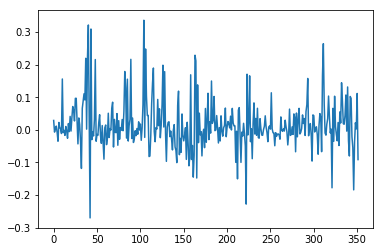

In [5]:
plt.figure()
plt.plot(Y)
plt.show()

In [6]:
import torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI
from pyro.optim import Adam

pyro.get_param_store().clear()

In [7]:
X_train, Y_train = Variable(torch.Tensor(X[:-30])), Variable(torch.Tensor(Y[:-30]))
X_test, Y_test = Variable(torch.Tensor(X[-30:])), Variable(torch.Tensor(Y[-30:]))
data = torch.cat((X_train, Y_train), 1)

In [8]:
# get array of batch indices
def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train.data.numpy()[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [9]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())

In [10]:
def guide(data):
    
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable((torch.ones(second_layer, first_layer) + 0.05 * torch.randn(second_layer, first_layer)).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable((torch.ones(second_layer) + 0.05 * torch.randn(second_layer)).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
#     w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
#     w_log_sig2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
#     b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
#     b_log_sig2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable((torch.ones(1, second_layer) + 0.05 * torch.randn(1, second_layer)).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable((torch.ones(1) + 0.05 * torch.randn(1)).type_as(data.data), requires_grad=True)
    
    
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [11]:
model(data)
guide(data)

/anaconda2/lib/python2.7/site-packages/pyro/__init__.py:57: RuntimeWarning: trying to observe a value outside of inference at obs
  RuntimeWarning)


Net(
  (hidden): Linear(in_features=49, out_features=25)
  (predict): Linear(in_features=25, out_features=1)
)

In [12]:
# instantiate optim and inference objects
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss="ELBO")

N = len(X_train.data.numpy())

for j in range(10000):
    epoch_loss = 0.0
    perm = torch.randperm(N)
    # shuffle data
    data = data[perm]
    # get indices of each batch
    all_batches = get_batch_indices(N, 64)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]        
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print("epoch avg loss {}".format(epoch_loss/float(N)))

epoch avg loss 4177.12428426
epoch avg loss 1357.77878736
epoch avg loss 1189.32982337
epoch avg loss 1132.04046365
epoch avg loss 1238.31113524
epoch avg loss 922.515054833
epoch avg loss 583.254267154
epoch avg loss 461.047631684
epoch avg loss 443.761589856
epoch avg loss 354.839821762
epoch avg loss 282.332173034
epoch avg loss 304.590024202
epoch avg loss 186.016384717
epoch avg loss 94.2681369189
epoch avg loss 149.879637914
epoch avg loss 70.9799535526
epoch avg loss 89.9730664366
epoch avg loss 74.8214899857
epoch avg loss 66.6747506657
epoch avg loss 56.2046607355
epoch avg loss 36.453363075
epoch avg loss 51.0174738724
epoch avg loss 28.6369932187
epoch avg loss 23.9943235409
epoch avg loss 21.7192405559
epoch avg loss 20.6271453289
epoch avg loss 15.6344268988
epoch avg loss 16.2849140049
epoch avg loss 13.0923778463
epoch avg loss 13.2701124108
epoch avg loss 12.2980668915
epoch avg loss 11.1371601176
epoch avg loss 8.94834037449
epoch avg loss 9.3660199657
epoch avg loss 9

In [13]:
y_preds = Variable(torch.zeros(30, 1))
for i in range(100):
    sampled_reg_model = guide(X_test)
    # run the regression model and add prediction to total
    y_preds = y_preds + sampled_reg_model(X_test)
# take the average of the predictions
y_preds = y_preds / 100

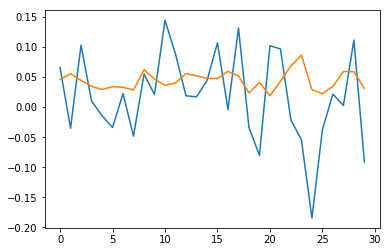

In [14]:
plt.figure()
plt.plot(Y_test.data.numpy())
plt.plot(y_preds.data.numpy())
plt.show()